# Prototypical Generative Model (PGM) training

In [77]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "proto_gen_model.ipynb"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.3"
# Don't turn on deterministic ops unless in need of pain
# os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

import numpy as np

import jax
import jax.random as random
import jax.numpy as jnp

import flax
flax.config.update('flax_use_orbax_checkpointing', True)
from flax.training import checkpoints

import ciclo
import wandb 

from clu import parameter_overview
from clu import deterministic_data

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["savefig.facecolor"] = "white"

from src.transformations import transform_image
from experiments.configs.inf_mnist import get_config as get_proto_config
from experiments.configs.gen_mnist import get_config as get_gen_config
from src.utils.input import get_data
from src.models.transformation_inference_model import TransformationInferenceNet, create_transformation_inference_state, make_transformation_inference_train_and_eval
from src.utils.proto_plots import plot_proto_model_training_metrics
from src.utils.gen_plots import plot_gen_model_training_metrics, plot_gen_dists
from src.models.transformation_generative_model import TransformationGenerativeNet, make_transformation_generative_train_and_eval, create_transformation_generative_state
from src.models.utils import reset_metrics
from src.utils.plotting import rescale_for_imshow
from src.utils.training import custom_wandb_logger


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
ANGLE = 180
proto_config = get_proto_config(f"{ANGLE}")

In [25]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=proto_config.to_dict(),
    mode="disabled",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

In [26]:
rng = random.PRNGKey(proto_config.seed)
data_rng, proto_init_rng, gen_init_rng = random.split(rng, 3)

## Get data

In [27]:
jax.local_device_count()

1

In [28]:
train_ds, val_ds, _ = get_data(proto_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

# TransformationInference Network (Prototype inference)

## Setup TrainState and NN

In [29]:
proto_model = TransformationInferenceNet(
    bounds=proto_config.get("augment_bounds", None),
    offset=proto_config.get("augment_offset", None),
    **proto_config.model.to_dict()
)

proto_state = create_transformation_inference_state(proto_model, proto_config, proto_init_rng, input_shape)

INFO:absl:
+--------------------------+--------------+-----------+-----------+--------+
| Name                     | Shape        | Size      | Mean      | Std    |
+--------------------------+--------------+-----------+-----------+--------+
| params/Dense_0/bias      | (2048,)      | 2,048     | 0.0       | 0.0    |
| params/Dense_0/kernel    | (784, 2048)  | 1,605,632 | -1.77e-05 | 0.0357 |
| params/Dense_1/bias      | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_1/kernel    | (2048, 1024) | 2,097,152 | 2.06e-05  | 0.0221 |
| params/Dense_2/bias      | (512,)       | 512       | 0.0       | 0.0    |
| params/Dense_2/kernel    | (1024, 512)  | 524,288   | 9.19e-05  | 0.0312 |
| params/Dense_3/bias      | (256,)       | 256       | 0.0       | 0.0    |
| params/Dense_3/kernel    | (512, 256)   | 131,072   | 1.48e-05  | 0.0442 |
| params/Dense_4/bias      | (5,)         | 5         | 0.0       | 0.0    |
| params/Dense_4/kernel    | (256, 5)     | 1,280     | 0.0      

In [30]:
train_step, eval_step = make_transformation_inference_train_and_eval(proto_model, proto_config)

In [32]:
total_steps = proto_config.steps
proto_final_state, history, _ = ciclo.train_loop(
    proto_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(total_steps * proto_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=total_steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=total_steps + 1,
)

15000/15000 [==============================] - 674s 45ms/step - invertibility_loss: 0.0027 - loss: 0.0678 - x_mse: 0.0676 - η_recon_loss: 0.1467 - invertibility_loss_test: 0.0028 - loss_test: 0.0683 - x_mse_test: 0.0680 - η_recon_loss_test: 0.1461 - label_paired_image_mse_test: 0.3903    000 ETA: 12:52:09 - invertibility_loss: 7.5807e-04 - loss: 0.1940 - x_mse: 0.1939 - η_recon_loss: 0.5985 - invertibility_loss_test: 0.0015 - loss_test: 0.4914 - x_mse_test: 0.4912 - η_recon_loss_test: 0.5967 - label_paired_image_mse_test: 0.0000 - ETA: 8:57:02 - invertibility_loss: 7.6315e-04 - loss: 0.1946 - x_mse: 0.1946 - η_recon_loss: 0.5984 - invertibility_loss_test: 0.0015 - loss_test: 0.4914 - x_mse_test: 0.4912 - η_recon_loss_test: 0.5967 - label_paired_image_mse_test: 0.0000e+00 - ETA: 7:46:24 - invertibility_loss: 7.5260e-04 - loss: 0.1938 - x_mse: 0.1937 - η_recon_loss: 0.5985 - invertibility_loss_test: 0.0015 - loss_test: 0.4914 - x_mse_test: 0.4912 - η_recon_loss_test: 0.5967 - label_paire

In [33]:
run.finish()

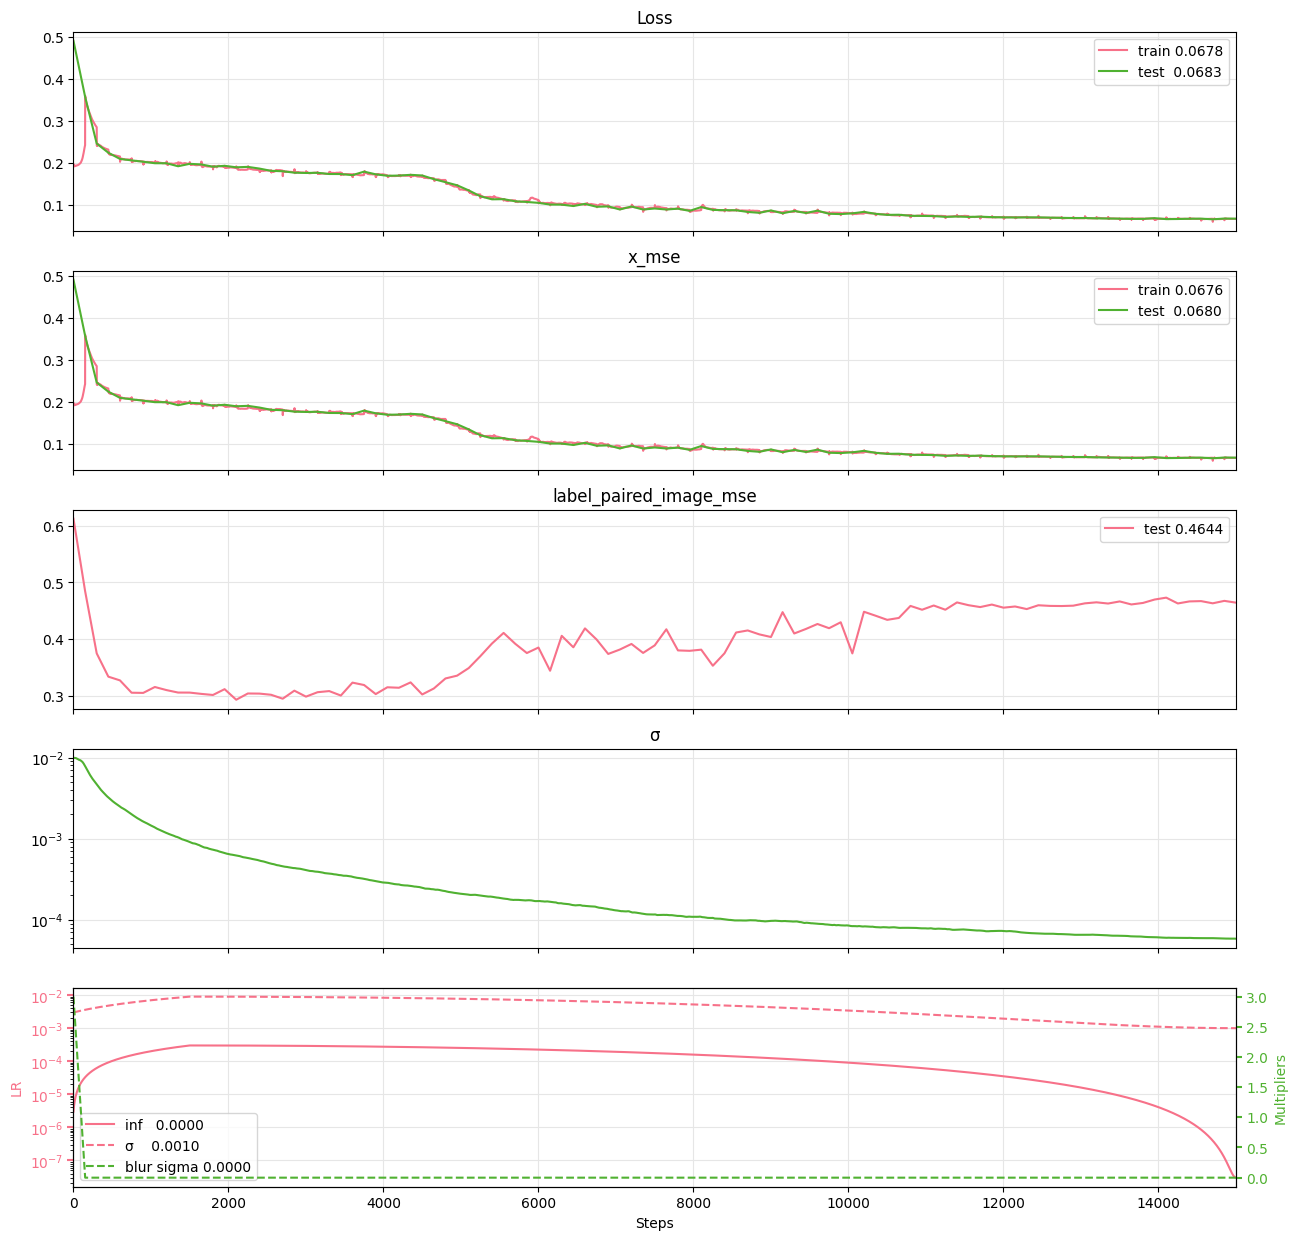

In [34]:
fig = plot_proto_model_training_metrics(history)

In [35]:
jax.nn.softplus(proto_final_state.params['σ_']).mean()

Array(5.849865e-05, dtype=float32)

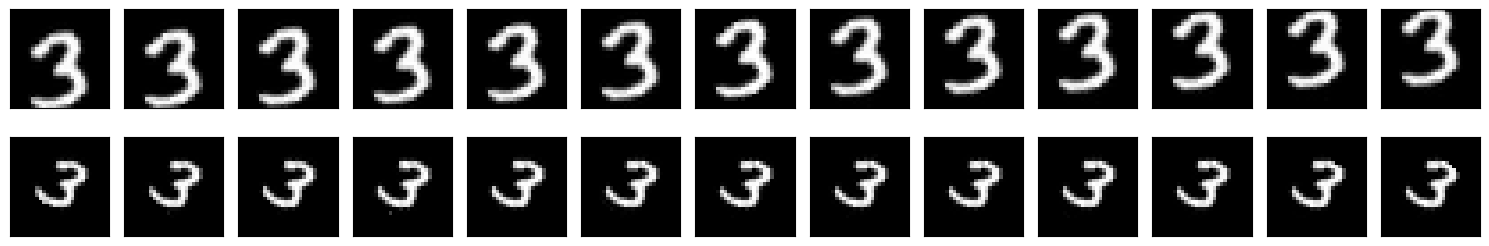

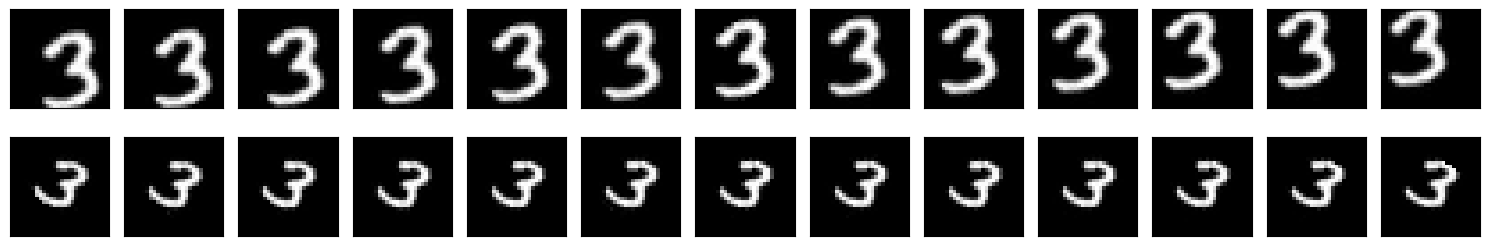

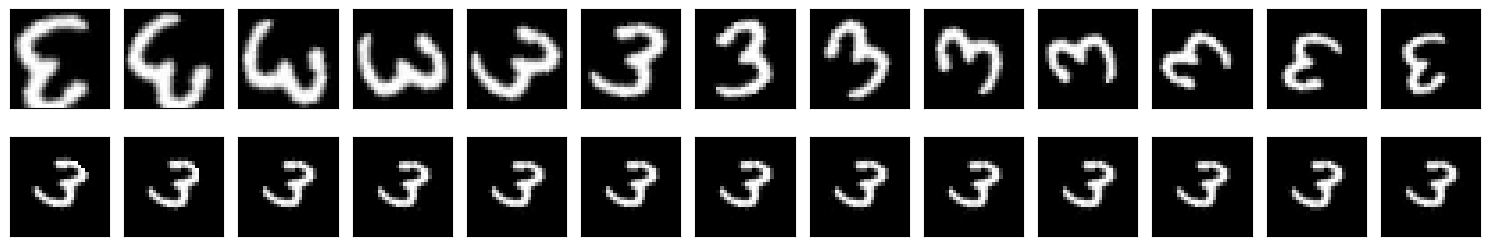

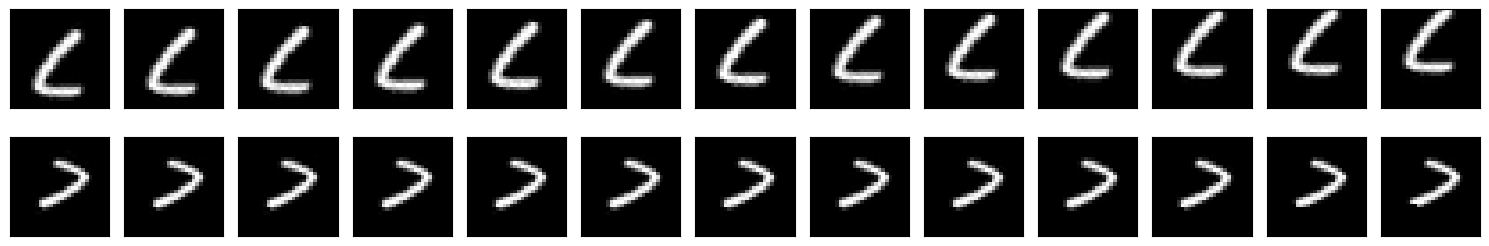

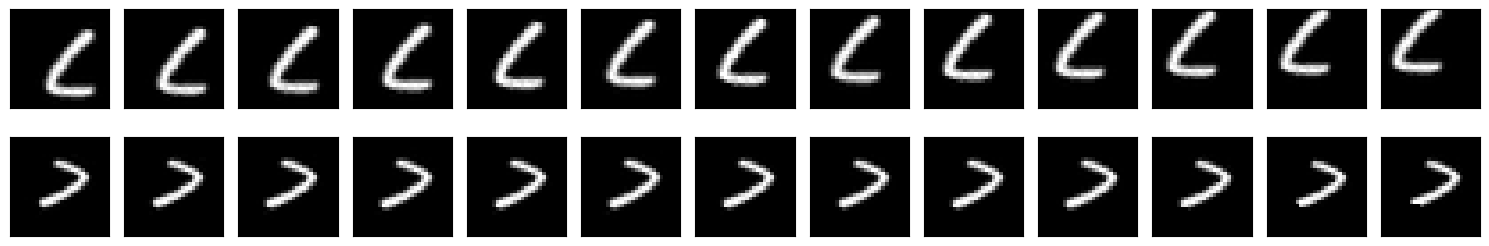

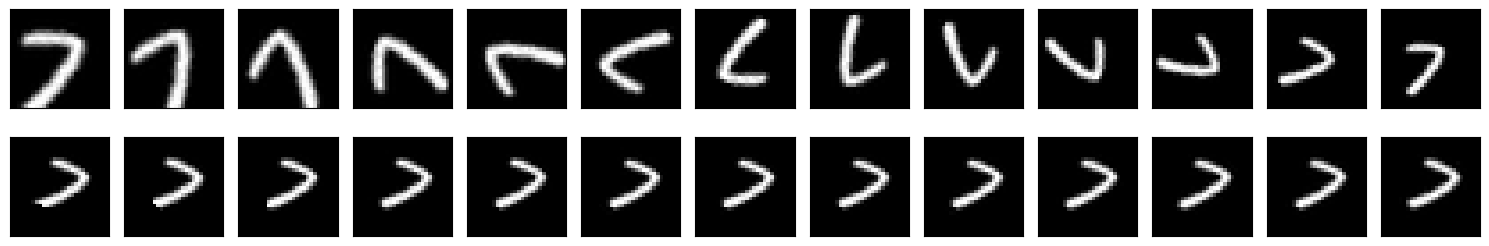

In [36]:
from src.transformations.affine import gen_affine_matrix_no_shear, transform_image_with_affine_matrix


val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

@jax.jit
def get_prototype(x):
    p_η = proto_model.apply({"params": proto_final_state.params}, x, train=False)
    η = p_η.sample(seed=rng)
    affine_matrix = gen_affine_matrix_no_shear(η)
    affine_matrix_inv = jnp.linalg.inv(affine_matrix)
    xhat = transform_image_with_affine_matrix(x, affine_matrix_inv, order=proto_config.interpolation_order)
    return xhat, η

for x_ in [
    val_batch['image'][0][14],
    val_batch['image'][0][12],
]:
    for mask in [
        # jnp.array([0, 0, 1, 0, 0]),
        jnp.array([0, 1, 0, 0, 0]),
        jnp.array([1, 1, 0, 0, 0]),
        # jnp.array([0, 0, 0, 1, 1]),
        jnp.array([1, 1, 1, 1, 1])
    ]:

        transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
            x_,
            jnp.linspace(-jnp.array(proto_config.augment_bounds[:5]) * mask, jnp.array(proto_config.augment_bounds[:5]) * mask, 13)
        )

        xhats, ηs = jax.vmap(get_prototype)(transformed_xs)

        fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

        for ax, x in zip(axs[0], list(transformed_xs)):
            ax.imshow(rescale_for_imshow(x), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        for ax, xhat in zip(axs[1], list(xhats)):
            ax.imshow(rescale_for_imshow(xhat), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

# Generative Network

## Define the prototype function

In [37]:
gen_config = get_gen_config(f"{ANGLE}")

In [40]:
print((3 * gen_config.model.num_bins + 1) * len(gen_config.augment_bounds), gen_config.model.conditioner.hidden_dims[-1])
# Note, we probably want the first number to be smaller than the second number. Haven't tested this yet.

95 256


In [45]:
train_ds, val_ds, _ = get_data(gen_config, data_rng)
input_shape = train_ds.element_spec["image"].shape[2:]

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': '

In [41]:
def prototype_function(x, rng):
    η = proto_model.apply({"params": proto_final_state.params}, x, train=False).sample(seed=rng)
    return η

In [47]:
gen_model = TransformationGenerativeNet(
    bounds=gen_config.get("augment_bounds", None),
    offset=gen_config.get("augment_offset", None),
    **gen_config.model.to_dict()
)

gen_state = create_transformation_generative_state(gen_model, gen_config, gen_init_rng, input_shape)

INFO:absl:
+-------------------------------------+-------------+-----------+-----------+--------+
| Name                                | Shape       | Size      | Mean      | Std    |
+-------------------------------------+-------------+-----------+-----------+--------+
| params/Conditioner_0/Dense_0/bias   | (256,)      | 256       | 0.0       | 0.0    |
| params/Conditioner_0/Dense_0/kernel | (261, 256)  | 66,816    | 0.000313  | 0.0618 |
| params/Conditioner_0/Dense_1/bias   | (256,)      | 256       | 0.0       | 0.0    |
| params/Conditioner_0/Dense_1/kernel | (256, 256)  | 65,536    | 3.32e-05  | 0.0623 |
| params/Conditioner_0/Dense_2/bias   | (95,)       | 95        | 0.0       | 0.0    |
| params/Conditioner_0/Dense_2/kernel | (256, 95)   | 24,320    | 0.0       | 0.0    |
| params/Conditioner_1/Dense_0/bias   | (256,)      | 256       | 0.0       | 0.0    |
| params/Conditioner_1/Dense_0/kernel | (261, 256)  | 66,816    | 0.00023   | 0.0619 |
| params/Conditioner_1/Dense_1/b

In [48]:
train_step, eval_step = make_transformation_generative_train_and_eval(gen_model, gen_config, prototype_function=prototype_function)

In [49]:
run = wandb.init(
    project="iclr2024experiments",
    entity="invariance-learners",
    config=gen_config.to_dict(),
    mode="disabled",
    notes="",
    name=None,
    settings=wandb.Settings(code_dir="../"),
)

In [50]:
gen_final_state, history, _ = ciclo.train_loop(
    gen_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
        ciclo.every(1): custom_wandb_logger(run=run)
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=int(gen_config.steps * gen_config.eval_freq),
    callbacks=[
        ciclo.keras_bar(total=gen_config.steps),
        # ciclo.early_stopping("loss_test", patience=total_steps // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        # ciclo.checkpoint("checkpoint", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=gen_config.steps + 1,
)

15000/15000 [==============================] - 389s 26ms/step - log_p_η_x_hat: 9.9321 - loss: -8.4369 - mae: 1.5028 - log_p_η_x_hat_test: 2.0970 - loss_test: -0.2619 - mae_test: 1.83514s - log_p_η_x_hat: 9.9169 - loss: -8.4385 - mae: 1.5024 - log_p_η_x_hat_test: 2.0


In [51]:
run.finish()

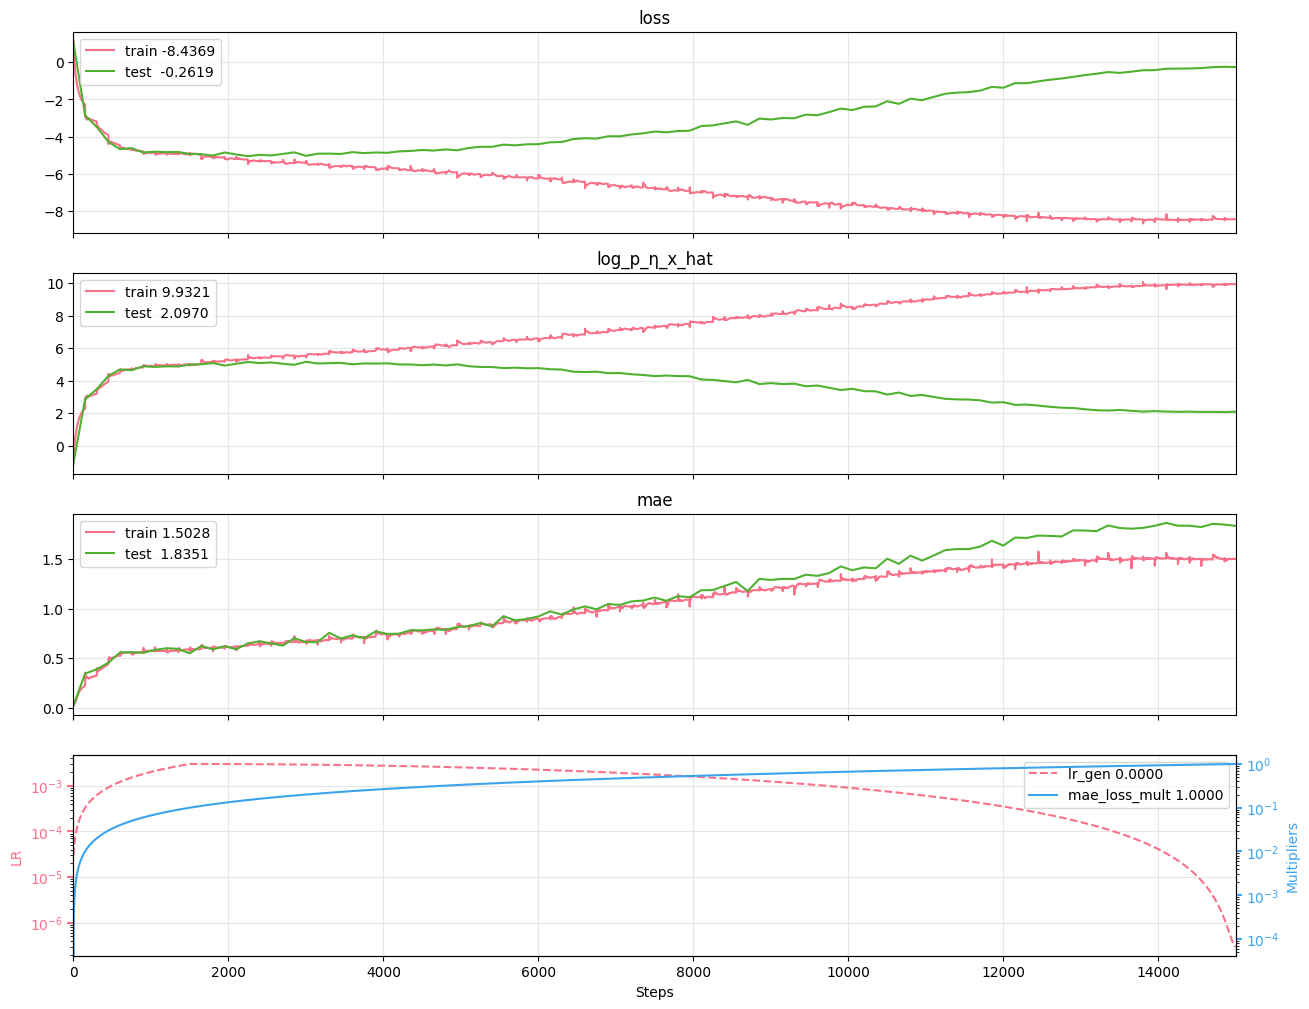

In [58]:
fig = plot_gen_model_training_metrics(history)

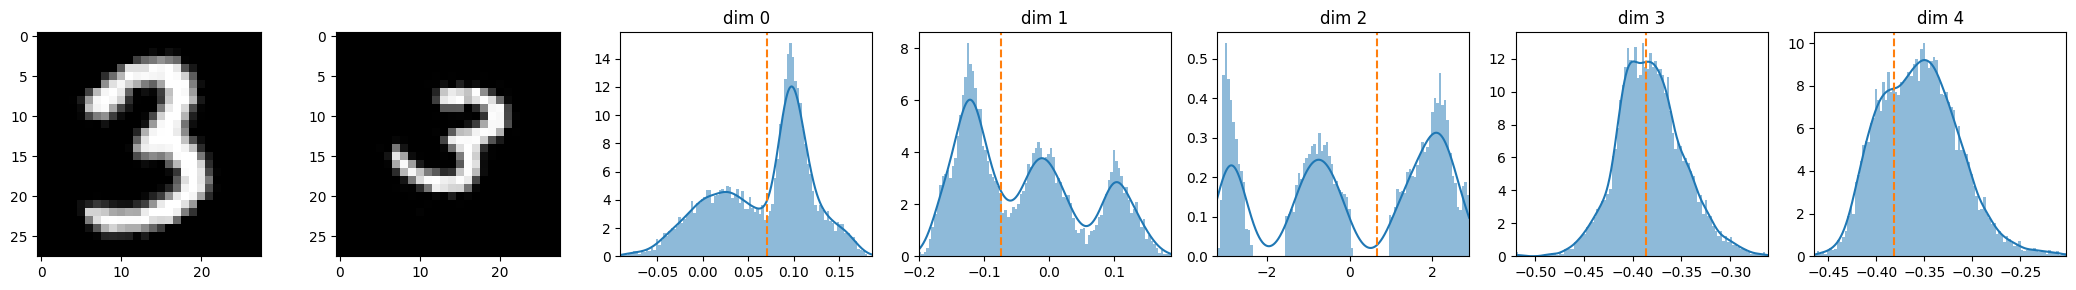

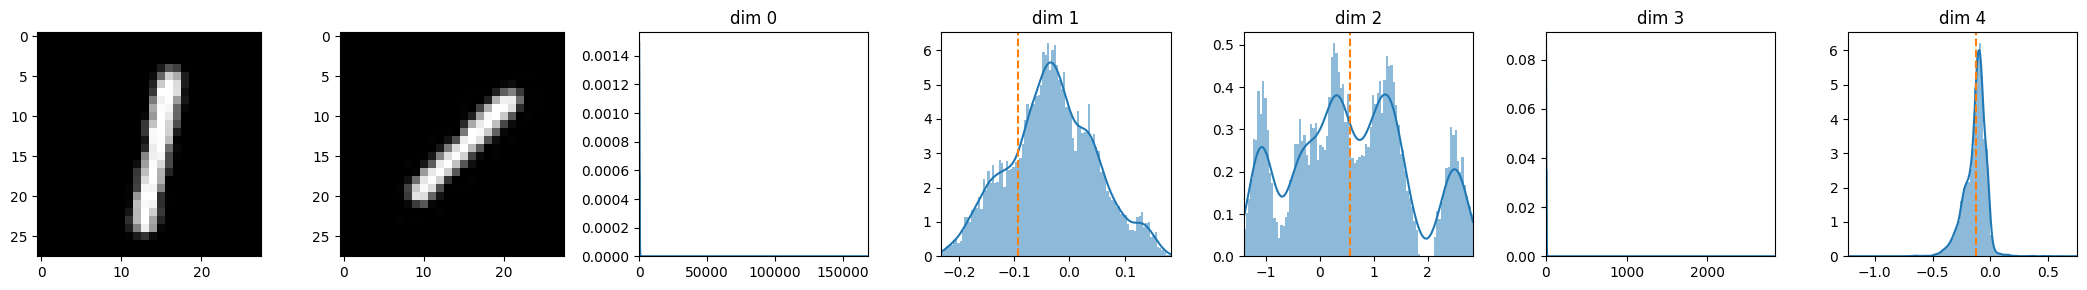

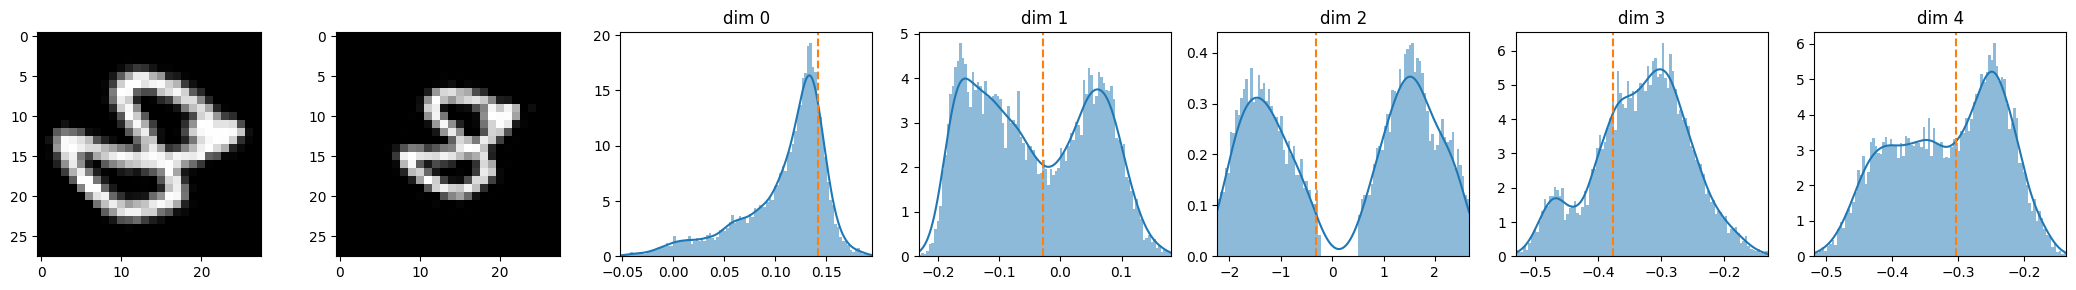

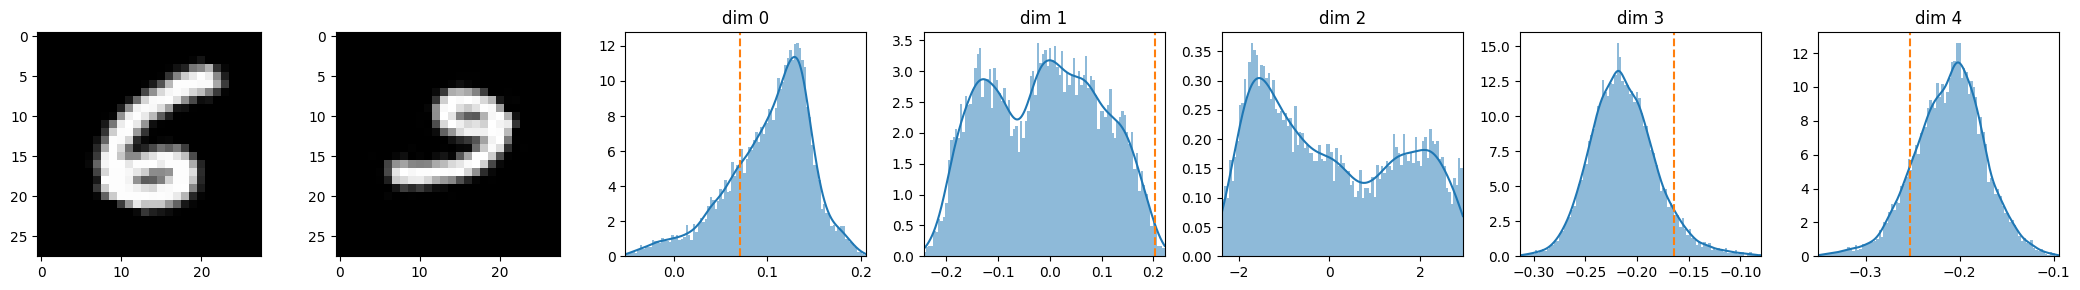

In [78]:
for x in [
    val_batch["image"][0][14],
    val_batch["image"][0][1],
    val_batch["image"][0][4],
    val_batch["image"][0][9],
]:
    plot_gen_dists(x, prototype_function, rng, gen_model, gen_final_state.params, gen_config)
    plt.show()
    plt.close(fig)

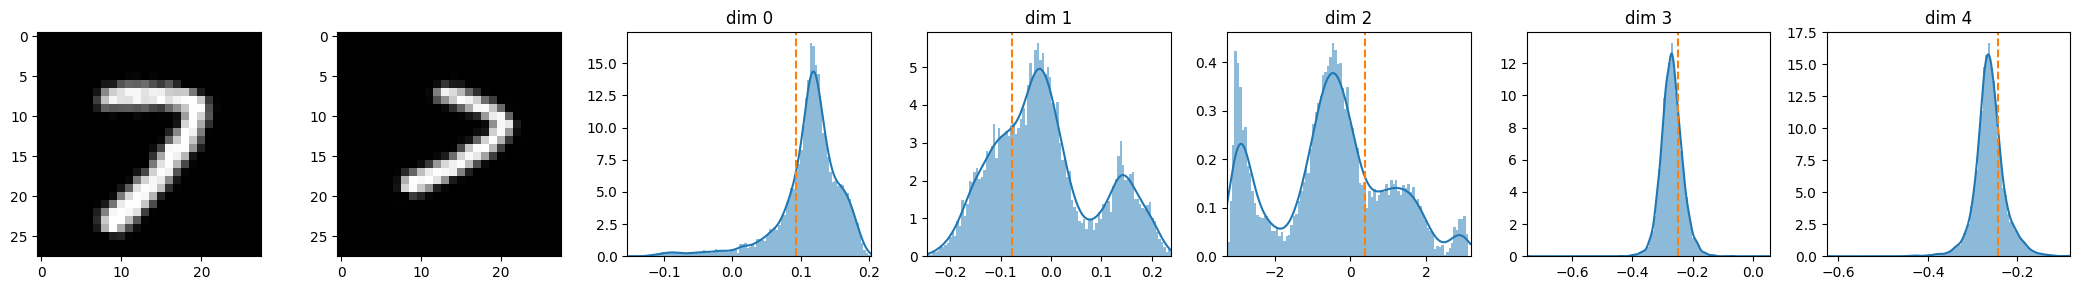

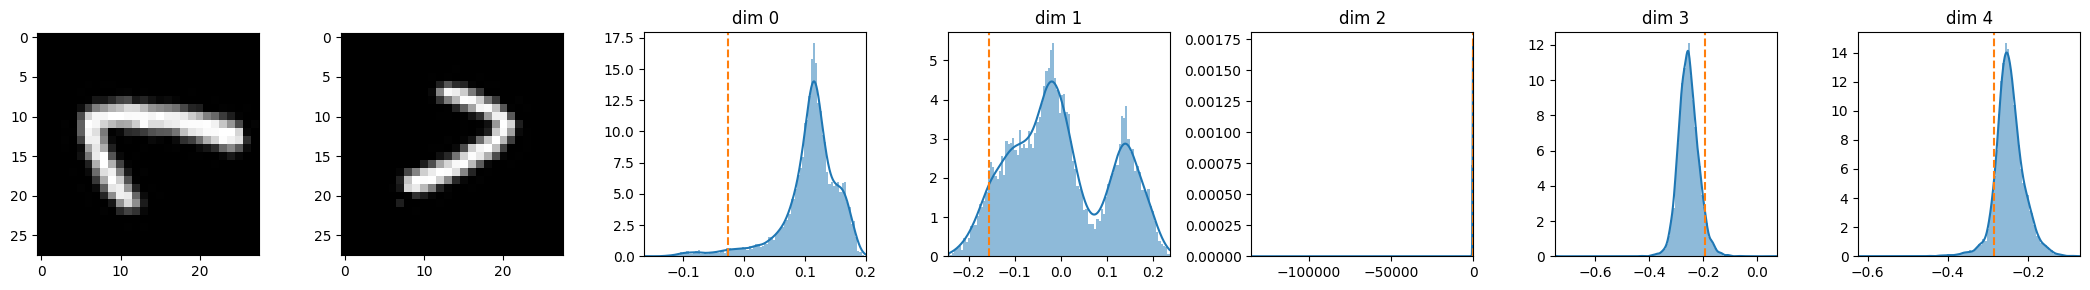

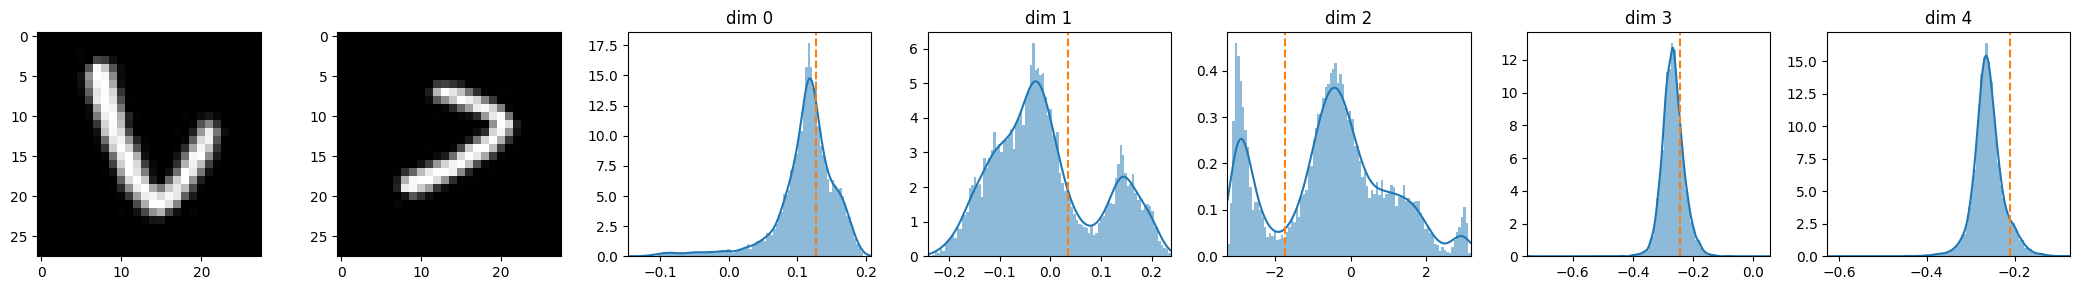

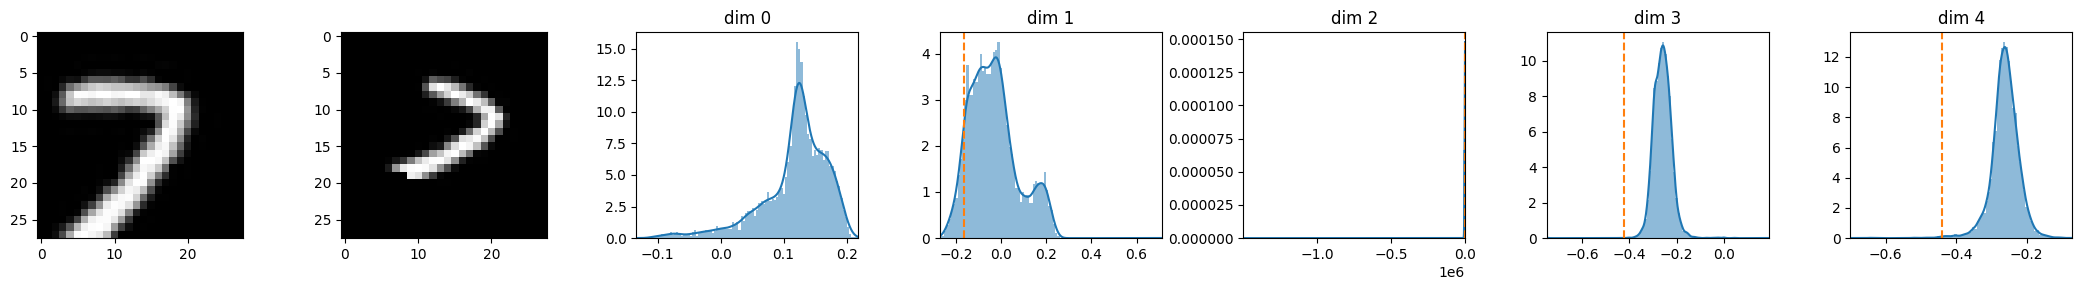

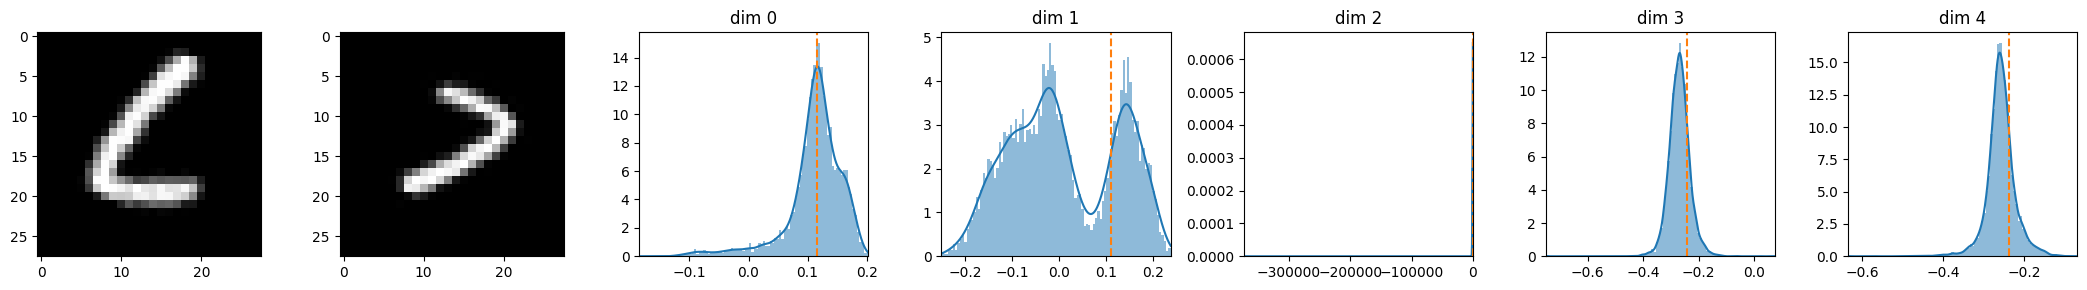

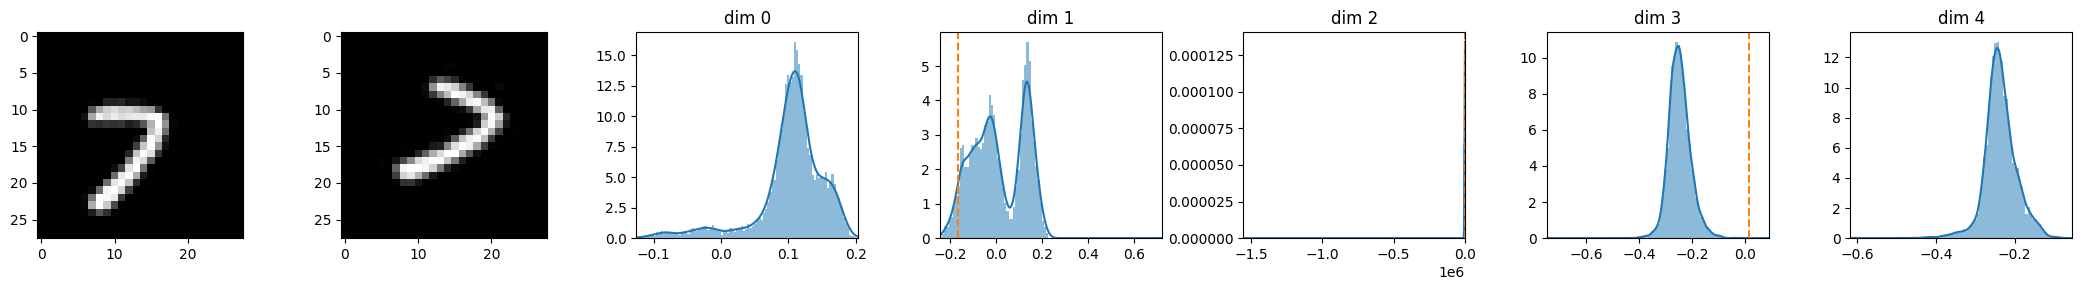

In [74]:
full_mask = jnp.array([1, 1, 1, 1, 1])
rot_mask = jnp.array([0, 0, 1, 0, 0])
transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(
    x_,
    jnp.concatenate((
        jnp.linspace(-jnp.array(gen_config.augment_bounds) * rot_mask, jnp.array(gen_config.augment_bounds) * rot_mask, 4)[:3],
        jnp.linspace(-jnp.array(gen_config.augment_bounds) * full_mask, jnp.array(gen_config.augment_bounds) * full_mask, 3),
    ))
)

for x in transformed_xs:
    plot_gen_dists(x, prototype_function, rng, gen_model, gen_final_state.params, gen_config)

[]

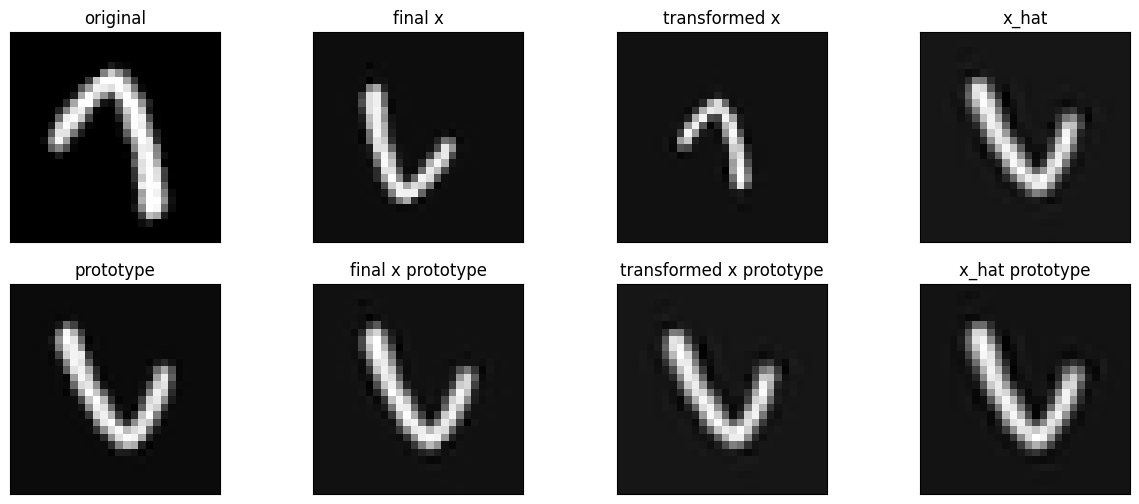

In [ ]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, jnp.array(config.augment_bounds))
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_prototype(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
